# Install
1. Download "quantlib" from http://www.lfd.uci.edu/~gohlke/pythonlibs/
2. Open with "WinPython Control Panel"    

### Some features
* TARGET - Trans-European Automated Real-time Gross settlement Express Transfer
* For all constants (spot, vol and etc.) use "SimpleQuote"

In [2]:
# Import QuantLib. 
# In fututre I'll change "*" to "ql."
import QuantLib as ql

In [3]:
# Import other lib's
import numpy as np
import pandas as pd

In [4]:
# Some magic for plot

In [5]:
%%capture
%pylab inline --no-import-all
import matplotlib.pyplot as plt
from IPython.display import display

# DateTime

### Set the evaluation time
It's required for futher actions

In [8]:
evaluationDate = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = evaluationDate

### DateTime Properties

In [13]:
date = ql.Date(30, 3, 2016)
print (date)

March 30th, 2016


In [15]:
print("Year = %s, Month = %s, DayOfMonth = %s, Tuesday = %s" % 
      (date.year(), date.month(), date.dayOfMonth(), date.weekday() == ql.Tuesday))

Year = 2016, Month = 3, DayOfMonth = 30, Tuesday = False


### DateTime Arithmetic

In [18]:
print(date + 1)
print(date - 1)
print(date + ql.Period(1, ql.Days))
print(date + ql.Period(1, ql.Weeks))
print(date + ql.Period(1, ql.Years))
print(date + 1 > date - 1)

March 31st, 2016
March 29th, 2016
March 31st, 2016
April 6th, 2016
March 30th, 2017
True


### DateTime Schedule (ex. Coupon Payments)

Here we have generated a Schedule object that will contain dates between date1 and date2 with the tenor specifying the Period to be every Month. The calendar object is used for determining holidays. The two arguments following the calendar in the Schedule constructor are the BussinessDayConvention. Here we chose the convention to be the day following holidays. That is why we see that holidays are excluded in the list of dates.

In [21]:
date1 = ql.Date(1, 1, 2016)
date2 = ql.Date(1, 1, 2017)
tenor = ql.Period(ql.Monthly)
calendar = ql.Russia()
schedule = ql.Schedule(date1, date2, tenor, calendar, ql.Following, ql.Following, ql.DateGeneration.Forward, False)
list(schedule)

[Date(11,1,2016),
 Date(1,2,2016),
 Date(1,3,2016),
 Date(1,4,2016),
 Date(3,5,2016),
 Date(1,6,2016),
 Date(1,7,2016),
 Date(1,8,2016),
 Date(1,9,2016),
 Date(3,10,2016),
 Date(1,11,2016),
 Date(1,12,2016),
 Date(9,1,2017)]

# Interest Rate

The InterestRate class can be used to store the interest rate with the compounding type, day count and the frequency of compounding. Below we show how to create an interest rate of 5.0% compounded annually, using Actual/Actual day count convention.

In [24]:
annualRate = 0.05
dayCount = ql.ActualActual()
compoundType = ql.Compounded
frequency = ql.Annual
interestRate = ql.InterestRate(annualRate, dayCount, compoundType, frequency)

Lets say if you invest a dollar at the interest rate described by interestRate, the compoundFactor method gives you how much your investment will be worth after t years. Below we show that the value returned by compoundFactor for 2 years agrees with the expected compounding formula.

In [25]:
print ((1.0 + annualRate)*(1.0 + annualRate)) # cum-rate for 2 years 
print(interestRate.compoundFactor(2.0)) 


1.1025
1.1025


The discountFactor method returns the reciprocal of the compoundFactor method. The discount factor is useful while calculating the present value of future cashflows.

In [26]:
print(1.0 / interestRate.compoundFactor(2.0)) 
print(interestRate.discountFactor(2.0)) 

0.9070294784580498
0.9070294784580498


Compare interest rates that have different compounding periods and/or payment frequencies.

In [28]:
newCompoundType = ql.Continuous
newRate = interestRate.equivalentRate(newCompoundType, frequency, 1)
print ("Rate with annual compounding is: %s, Equivalent one year annual continuously compounded rate is: %s" %
       (interestRate.rate(), newRate.rate()))

newFrequency = ql.Semiannual
newRate = interestRate.equivalentRate(compoundType, newFrequency, 1)
print ("Rate with annual compounding is: %s, Equivalent one year semi-annually compounded rate is: %s" %
       (interestRate.rate(), newRate.rate()))

Rate with annual compounding is: 0.05, Equivalent one year annual continuously compounded rate is: 0.04879016416943204
Rate with annual compounding is: 0.05, Equivalent one year semi-annually compounded rate is: 0.04939015319191986


# Modeling Fixed Rate Bonds

Let's consider a hypothetical bond with a par value of 100, that pays 6% coupon semi-annually issued on January 15th, 2015 and set to mature on January 15th, 2016. The bond will pay a coupon on July 15th, 2015 and January 15th, 2016. The par amount of 100 will also be paid on the January 15th, 2016.

To make things simpler, lets assume that we know the spot rates of the treasury as of January 15th, 2015. The annualized spot rates are 0.5% for 6 months and 0.7% for 1 year point. Lets calculate the fair value of this bond.

$$ P=(\frac{C}{1+i} + \frac{C}{(1+i)^2} + \cdots + \frac{C}{(1+i)^N}) + \frac{M}{(1+i)^N} $$    

In [29]:
P = 3 / pow(1 + 0.005, 0.5) + 3 / (1 + 0.007) + 100 / (1 + 0.007)
print (P)

105.27653992490681


Lets calculate the same thing using QuantLib.

In [32]:
spotDates = [ql.Date(15, 1, 2015), ql.Date(15, 7, 2015), ql.Date(15, 1, 2016)]
spotRates = [0.0, 0.005, 0.007]
dayCount = ql.Thirty360()
calendar = ql.Russia()
interpolation = ql.Linear()
compounding = ql.Compounded
compoundingFrequency = ql.Annual
spotCurve = ql.ZeroCurve(spotDates, spotRates, dayCount, calendar, interpolation, compounding, compoundingFrequency)
spotCurveHandle = ql.YieldTermStructureHandle(spotCurve)

So far we have created the term structure and the variables are rather self explanatory. Now lets construct the fixed rate bond.

In [33]:
issueDate = ql.Date(15, 1, 2015)
maturityDate = ql.Date(15, 1, 2016)
tenor = ql.Period(ql.Semiannual)
calendar = ql.Russia()
bussinessConvention = ql.Unadjusted
dateGeneration = ql.DateGeneration.Backward
monthEnd = False
schedule = ql.Schedule(issueDate, maturityDate, tenor, calendar, 
                    bussinessConvention, bussinessConvention , dateGeneration, monthEnd)
list(schedule)

[Date(15,1,2015), Date(15,7,2015), Date(15,1,2016)]

Now lets build the coupon

In [34]:
dayCount = ql.Thirty360()
couponRate = 0.06
coupons = [couponRate]

Now lets construct the FixedRateBond

In [35]:
settlementDays = 0
faceValue = 100
fixedRateBond = ql.FixedRateBond(settlementDays, faceValue, schedule, coupons, dayCount)

Create a bond engine with the term structure as input and set the bond to use this bond engine

In [36]:
bondEngine = ql.DiscountingBondEngine(spotCurveHandle)
fixedRateBond.setPricingEngine(bondEngine)

Finally the price

In [37]:
fixedRateBond.NPV()

105.27653992490683

In [38]:
print("Manually Calc: %s \nQuantlib Calc: %s" % (P, fixedRateBond.NPV()))

Manually Calc: 105.27653992490681 
Quantlib Calc: 105.27653992490683


# Interest Rate Term Structure

Term structure is pivotal to pricing securities. One would need a YieldTermStructure object created in QuantLib to use with pricing engines. In an earlier post on modeling bonds using QuantLib we discussed how to use spot rates directly with bond pricing engine. Here in this post we will show how to bootstrap yield curve using QuantLib.

The deposit rates and fixed rate bond rates are provided below. This example is based on Exhibit 5-5 given in Frank Fabozzi's Bond Markets, Analysis and Strategies, Sixth Edition.

In [39]:
depo_maturities = [ql.Period(6, ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.5]

bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15, 7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

Lets define some of the constants required for the rest of the objects needed below.

In [40]:
calendar = ql.Russia()
bussiness_convention = ql.Unadjusted
day_count = ql.Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

The basic idea of bootstrapping using QuantLib is to use the deposit rates and bond rates to create individual helpers. Then use the combination of the two helpers to construct the yield curve.

In [41]:
depo_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                     m,
                                     settlement_days,
                                     calendar,
                                     bussiness_convention,
                                     end_of_month,
                                     day_count )
                for r, m in zip(depo_rates, depo_maturities)]

The rest of the points are coupon bonds. We assume that the YTM given for the bonds are all par rates. So we have bonds with coupon rate same as the YTM.

In [44]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = evaluationDate + m
    schedule = ql.Schedule(evaluationDate,
                   termination_date,
                   coupon_frequency,
                   calendar,
                   bussiness_convention,
                   bussiness_convention,
                   ql.DateGeneration.Backward,
                   end_of_month)

    helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                        settlement_days,
                                        face_amount,
                                        schedule,
                                        [r/100.0],
                                        day_count,
                                        bussiness_convention,
                                        )
    bond_helpers.append(helper)

The yield curve is constructed by putting the two helpers together.

In [45]:
rate_helpers = depo_helpers + bond_helpers
yieldcurve = ql.PiecewiseLogCubicDiscount(evaluationDate, rate_helpers, day_count)

The spot rates is obtined from yieldcurve object using the zeroRate method.

In [46]:
spots = []
tenors = []
for d in yieldcurve.dates():
    yrs = day_count.yearFraction(evaluationDate, d)
    compounding = ql.Compounded
    freq = ql.Semiannual
    zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
    tenors.append(yrs)
    eq_rate = zero_rate.equivalentRate(day_count,
                                       compounding,
                                       freq,
                                       evaluationDate,
                                       d).rate()
    spots.append(100*eq_rate)
    
yield_by_date = list(zip(yieldcurve.dates(),spots))    
yield_by_date

[(Date(15,1,2015), 0.0),
 (Date(15,7,2015), 5.249999999999977),
 (Date(15,1,2016), 5.426385841741377),
 (Date(15,7,2016), 5.761159915065495),
 (Date(15,1,2017), 6.02028023895036),
 (Date(15,7,2017), 6.283174634314381),
 (Date(15,1,2018), 6.550263777152754),
 (Date(15,7,2018), 6.82205349935372),
 (Date(15,1,2019), 6.870031609633287),
 (Date(15,7,2019), 7.095268816200129),
 (Date(15,1,2020), 7.205095653056404),
 (Date(15,7,2020), 7.256506795000028),
 (Date(15,1,2021), 7.309874764399638),
 (Date(15,7,2021), 7.428853261444912),
 (Date(15,1,2022), 7.484915052187002),
 (Date(15,7,2022), 7.542695889109563),
 (Date(15,1,2023), 7.6708686984454655),
 (Date(15,7,2023), 7.802044924051543),
 (Date(15,1,2024), 7.7908150490884065),
 (Date(15,7,2024), 7.929397594780907),
 (Date(15,1,2025), 8.071649125651659)]

# Hull White Term Structure Simulations

The Hull-White Short Rate Model is defined as:

$$ dr_t = (\theta(t) - a r_t)dt + \sigma dW_t $$

where $a$ and $ \sigma $ are constants, and $\theta(t)$ is
chosen in order to fit the input term structure of interest rates.
Here we use QuantLib to show how to simulate the Hull-White model
and investigate some of the properties.

The constants that we use for this example is all defined as shown below. Variables $sigma$ and $a$ are the constants that define the Hull-White model. In the simulation, we discretize the time span of length 30 years into 360 intervals (one per month) as defined by the timestep variable. For simplicity we will use a constant forward rate term structure as an input. It is straight forward to swap with another term structure here.

In [48]:
sigma = 0.1
a = 0.1
timestep = 360
length = 30 # in years
forward_rate = 0.05
day_count = ql.Thirty360()

In [49]:
spot_curve = ql.FlatForward(evaluationDate, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [50]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

The Hull-White process is constructed by passing the term-structure, $a$ and $sigma$. To create the path generator, one has to provide a random sequence generator along with other simulation inputs such as timestep and length.
A function to generate paths can be written as shown below:

In [51]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

The simulation of the short rates look as shown below:

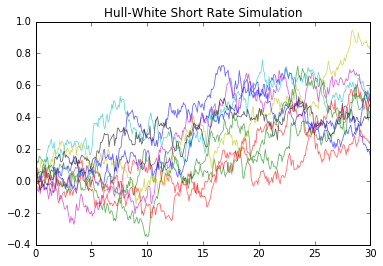

In [52]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

The short rate $r(t)$ is given a distribution with the properties:

$$ E\{r(t) | F_s\} = r(s)e^{-a(t-s)}  + \alpha(t) - \alpha(s)e^{-a(t-s)} $$
   $$ Var\{ r(t) | F_s \} = \frac{\sigma^2}{2a} [1 - e^{-2a(t-s)}] $$
   where 
   $$ \alpha(t) = f^M(0, t) + \frac{\sigma^2} {2a^2}(1-e^{-at})^2$$
   
as shown in Brigo & Mercurio's book on Interest Rate Models.

In [53]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)

The mean and variance compared between the simulation (red dotted line) and theory (blue line).

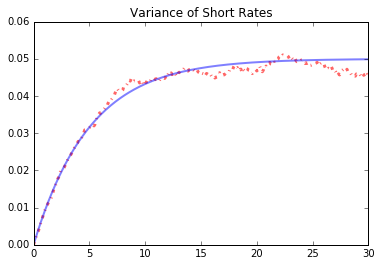

In [54]:
vol = [np.var(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, vol, "r-.", lw=3, alpha=0.6)
plt.plot(time,sigma*sigma/(2*a)*(1.0-np.exp(-2.0*a*np.array(time))), "b-", lw=2, alpha=0.5)
plt.title("Variance of Short Rates")

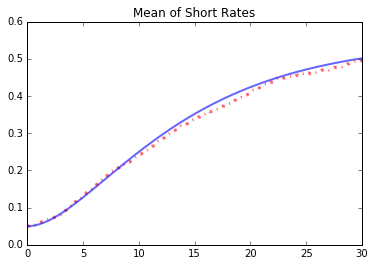

In [55]:
def alpha(forward, sigma, a, t):
    return forward + 0.5* np.power(sigma/a*(1.0 - np.exp(-a*t)), 2)

avg = [np.mean(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, avg, "r-.", lw=3, alpha=0.6)
plt.plot(time,alpha(forward_rate, sigma, a, time), "b-", lw=2, alpha=0.6)
plt.title("Mean of Short Rates")

# European Option Pricing using Black-Scholes-Merton model

Let us consider a European call option for AAPL with a strike price of \$130 maturing on 15th Jan, 2016. Let the spot price be \$127.62. The volatility of the underlying stock is know to be 20%, and has a dividend yield of 1.63%. Lets value this option as of evaluationDate.

In [56]:
maturity_date = ql.Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols for a year
dividend_rate =  0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.TARGET() # Trans-European Automated Real-time Gross settlement Express Transfer

Construct the European option

In [57]:
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

Construct The Black-Scholes-Merton process

In [58]:
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(evaluationDate, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)

Lets compute the theoretical price using the AnalyticEuropeanEngine

In [59]:
engine = ql.AnalyticEuropeanEngine(bsm_process)
european_option.setPricingEngine(engine)
bs_price = european_option.NPV()
print ("The theoretical price is:", bs_price)

The theoretical price is: 8.160628781301915


# European Option Pricing using Binominal-tree approach

In [61]:
def binomial_price(bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    european_option.setPricingEngine(binomial_engine)
    return european_option.NPV()

steps = range(2, 100, 1)
prices = [binomial_price(bsm_process, step) for step in steps]

In the plot below, we show the convergence of binomial-tree approach by comparing its price with the BSM price.

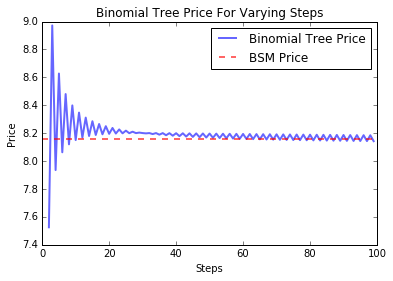

In [62]:
plt.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
plt.plot([0,100],[bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()

# European Option Pricing using Black model

Let us consider a European call option for AAPL with a strike price of \$130 maturing on 15th Jan, 2016. Let the spot price be \$127.62. The volatility of the underlying stock is know to be 20%. Lets value this option as of evaluationDate.

In [64]:
maturity_date = ql.Date(15, 1, 2016)
spot = 127.62
strike = 130
volatility = 0.20 # the historical vols for a year
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.TARGET() # Trans-European Automated Real-time Gross settlement Express Transfer

Construct the European option

In [65]:
payoff = ql.PlainVanillaPayoff(option_type, strike)
exercise = ql.EuropeanExercise(maturity_date)
option = ql.VanillaOption(payoff, exercise)

Construct The Black process

In [66]:
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
risk_free_ts = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, risk_free_rate, day_count))
volatitlity = ql.BlackConstantVol(evaluationDate, calendar, volatility, day_count)
b_process = ql.BlackProcess(spot_handle, risk_free_ts, ql.BlackVolTermStructureHandle(volatitlity))

Lets compute the theoretical price using the AnalyticEuropeanEngine

In [67]:
engine = ql.AnalyticEuropeanEngine(b_process)

In [68]:
option.setPricingEngine(engine)

In [69]:
print (option.NPV())
print (option.delta())
print (option.gamma())
print (option.vega())
print (option.rho())
print (option.theta())

9.104947673341693
0.502534428176759
0.015614009858092526
50.860652259803246
55.028496050576244
-5.076960278306983


# European Option Pricing using Heston model

Heston model can be used to value options by modeling the underlying asset such as the stock of a company. The one major feature of the Heston model is that it inocrporates a stochastic volatility term.

\begin{eqnarray}
dS_t &=& \mu S_tdt + \sqrt{V_t} S_t dW_t^1 \\
dV_t &=& \kappa(\theta-V_t) + \sigma \sqrt{V_t} dW_t^2
\end{eqnarray}

* $S_t$  is the asset's value at time tt
* $\mu$ is the expected growth rate of the log normal stock value
* $V_t$ is the variance of the asset $S_t$
* $W_t^1$ is the stochastic process governing the $S_t$ process
* $\theta$ is the value of mean reversion for the variance $V_t$
* $\kappa$ is the strengh of mean reversion
* $\sigma$ is the volatility of volatility
* $W_t^2$ is the stochastic process governing the $V_t$ process
* The correlation between $W_t^1$ and $W_t^2$ is $ρ$

In contrast, the Black-Scholes-Merton process assumes that the volatility is constant.

Let us consider a European call option for AAPL with a strike price of \$130 maturing on 15th Jan, 2016. Let the spot price be \$127.62. The volatility of the underlying stock is know to be 20%, and has a dividend yield of 1.63%. We assume a short term risk free rate of 0.1%. Lets value this option as of 8th May, 2015.

In [70]:
maturity_date = ql.Date(15, 1, 2016)
spot = ql.SimpleQuote(127.62)
strike = 130
volatility = 0.20 # the historical vols for a year
dividend_rate = 0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.TARGET() # Trans-European Automated Real-time Gross settlement Express Transfer

Construct the European option

In [71]:
payoff = ql.PlainVanillaPayoff(option_type, strike)
exercise = ql.EuropeanExercise(maturity_date)
option = ql.VanillaOption(payoff, exercise)

In order to price the option using the Heston model, we first create the Heston process. In order to create the Heston process, we use the parameter values: 
* the spot variance v0 = volatility*volatility = 0.04
* mean reversion strength kappa = 0.1
* the mean reversion variance theta=v0
* volatility of volatility sigma = 0.1 
* the correlation between the asset price and its variance is rho = -0.75.

In [72]:
v0 = 0.04
kappa = 0.1
theta = v0
sigma = 0.1
rho = -0.75

In [74]:
spot_handle = ql.QuoteHandle(spot)
risk_free_ts = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, dividend_rate, day_count)) 

# Maybe possible define such as:
# ts = YieldTermStructureHandle(FlatForward(0, TARGET(), 0.0, Actual360()))

Construct the Heston model

In [75]:
heston_process = ql.HestonProcess(risk_free_ts, dividend_ts, spot_handle, v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)

Lets compute the theoretical price using the AnalyticEuropeanEngine

In [76]:
engine = ql.AnalyticHestonEngine(heston_model)
option.setPricingEngine(engine)

In [77]:
option.NPV()

7.827944594291182

Create another one option

In [78]:
option_type_new = ql.Option.Put
strike_new = 130
maturity_date_new = ql.Date(15, 1, 2016)

payoff_new = ql.PlainVanillaPayoff(option_type_new, strike_new)
exercise_new = ql.EuropeanExercise(maturity_date_new)
option_new = ql.VanillaOption(payoff_new, exercise_new)

option_new.setPricingEngine(engine)

Make plot

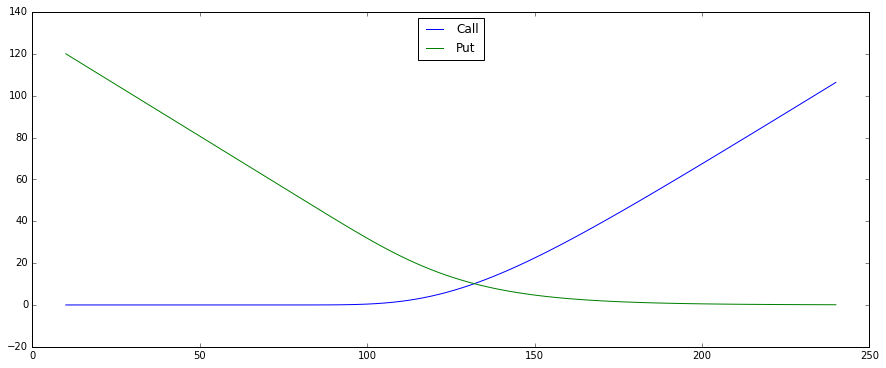

In [79]:
xs = numpy.linspace(10, 240.0, 100)
ys = []
ys2 = []
for x in xs:
    spot.setValue(x)
    ys.append(option.NPV())
    ys2.append(option_new.NPV())
    
plt.figure(figsize=(15, 6), dpi=80)
plt.subplot(1, 1, 1)
plt.plot(xs, ys, color="blue", linewidth=1.0, linestyle="-", label = "Call")
plt.plot(xs, ys2, color="green", linewidth=1.0, linestyle="-", label = "Put")
plt.legend(loc='upper center')    

# Modeling Vanilla Interest Rate Swaps 

An Interest Rate Swap is a financial derivative instrument in which two parties agree to exchange interest rate cash flows based on a notional amount from a fixed rate to a floating rate or from one floating rate to another floating rate.

Here we will consider an example of a plain vanilla USD swap with 10 million notional and 10 year maturity. Let the fixed leg pay 2.5% coupon semiannually, and the floating leg pay Libor 3m quarterly.

Construct discount curve and libor curve

In [80]:
risk_free_rate = 0.01
libor_rate = 0.02
day_count = ql.Actual365Fixed()

discount_curve = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, risk_free_rate, day_count))
libor_curve = ql.YieldTermStructureHandle(ql.FlatForward(evaluationDate, libor_rate, day_count))

#libor3M_index = ql.Euribor3M(libor_curve)  
libor3M_index = ql.USDLibor(ql.Period(3, ql.Months), libor_curve)

To construct the Swap instrument, we have to specify the fixed rate leg and floating rate leg. We construct the fixed rate and floating rate leg schedules below.

In [84]:
calendar = ql.UnitedStates()
settle_date = calendar.advance(evaluationDate, 5, ql.Days)
maturity_date = calendar.advance(settle_date, 10, ql.Years)

fixed_leg_tenor = ql.Period(6, ql.Months)
fixed_schedule = ql.Schedule(settle_date, 
                          maturity_date, 
                          fixed_leg_tenor,
                          calendar,
                          ql.ModifiedFollowing,
                          ql.ModifiedFollowing,
                          ql.DateGeneration.Forward, 
                          False)

float_leg_tenor = ql.Period(3, ql.Months)
float_schedule = ql.Schedule(settle_date,
                          maturity_date,
                          float_leg_tenor,
                          calendar,
                          ql.ModifiedFollowing, 
                          ql.ModifiedFollowing,
                          ql.DateGeneration.Forward,
                          False)

Below, we construct a VanillaSwap object by including the fixed and float leg schedules created above.

In [85]:
notional = 10000000
fixed_rate = 0.025
fixed_leg_daycount = ql.Actual360()
float_leg_daycount = ql.Actual360()
float_spread = 0.004

ir_swap = ql.VanillaSwap(ql.VanillaSwap.Payer,
                      notional,
                      fixed_schedule,
                      fixed_rate,
                      fixed_leg_daycount,
                      float_schedule,
                      libor3M_index,
                      float_spread,
                      float_leg_daycount)

We evaluate the swap using a discounting engine.

In [86]:
swap_engine = ql.DiscountingSwapEngine(discount_curve)
ir_swap.setPricingEngine(swap_engine)

#### Result Analysis

The cashflows for the fixed and floating leg can be extracted from the ir_swap object. The fixed leg cashflows are shown below:

In [87]:
for i, cf in enumerate(ir_swap.leg(0)):
    print ("%2d  %-20s  %10.2f" % (i+1, cf.date(), cf.amount()))

 1  July 23rd, 2015        125694.44
 2  January 25th, 2016     129166.67
 3  July 25th, 2016        126388.89
 4  January 23rd, 2017     126388.89
 5  July 24th, 2017        126388.89
 6  January 23rd, 2018     127083.33
 7  July 23rd, 2018        125694.44
 8  January 23rd, 2019     127777.78
 9  July 23rd, 2019        125694.44
10  January 23rd, 2020     127777.78
11  July 23rd, 2020        126388.89
12  January 25th, 2021     129166.67
13  July 23rd, 2021        124305.56
14  January 24th, 2022     128472.22
15  July 25th, 2022        126388.89
16  January 23rd, 2023     126388.89
17  July 24th, 2023        126388.89
18  January 23rd, 2024     127083.33
19  July 23rd, 2024        126388.89
20  January 23rd, 2025     127777.78


In [88]:
for i, cf in enumerate(ir_swap.leg(1)):
    print ("%2d  %-20s  %10.2f" % (i+1, cf.date(), cf.amount()))

 1  April 23rd, 2015        59436.87
 2  July 23rd, 2015         60098.65
 3  October 23rd, 2015      60760.46
 4  January 25th, 2016      62084.17
 5  April 25th, 2016        60098.65
 6  July 25th, 2016         60098.65
 7  October 24th, 2016      60098.65
 8  January 23rd, 2017      60098.65
 9  April 24th, 2017        60098.65
10  July 24th, 2017         60098.65
11  October 23rd, 2017      60098.65
12  January 23rd, 2018      60760.46
13  April 23rd, 2018        59436.87
14  July 23rd, 2018         60098.65
15  October 23rd, 2018      60760.46
16  January 23rd, 2019      60760.46
17  April 23rd, 2019        59436.87
18  July 23rd, 2019         60098.65
19  October 23rd, 2019      60760.46
20  January 23rd, 2020      60760.46
21  April 23rd, 2020        60098.65
22  July 23rd, 2020         60098.65
23  October 23rd, 2020      60760.46
24  January 25th, 2021      62084.17
25  April 23rd, 2021        58113.40
26  July 23rd, 2021         60098.65
27  October 25th, 2021      62084.17
2

Some other analytics such as the fair value, fair spread etc can be extracted as shown below.

In [89]:
print ("%-20s: %20.3f" % ("Net Present Value", ir_swap.NPV()))
print ("%-20s: %20.3f" % ("Fair Spread", ir_swap.fairSpread()))
print ("%-20s: %20.3f" % ("Fair Rate", ir_swap.fairRate()))
print ("%-20s: %20.3f" % ("Fixed Leg BPS", ir_swap.fixedLegBPS()))
print ("%-20s: %20.3f" % ("Floating Leg BPS", ir_swap.floatingLegBPS()))

Net Present Value   :          -115050.676
Fair Spread         :                0.005
Fair Rate           :                0.024
Fixed Leg BPS       :            -9629.716
Floating Leg BPS    :             9641.779
